## Trying Hugging Face DDPM implementation

In [23]:
# Loading Dependencies
!pip install -q -U einops datasets matplotlib tqdm

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Excellent libary for Rearanging Dimensions of inputs in pytorch
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

"""
Example:
  x = torch.randn(2, 3, 4)  # shape: (batch_size, height, width)
  rearranged_x = Rearrange('b h w -> b w h')(x)
  print(rearranged_x.shape)  # Output: torch.Size([2, 4, 3])
"""

import torch
from torch import nn, einsum
import torch.nn.functional as F

### Network Helping Classes

In [24]:
# Checks if a value exists
def exists(x):
    """
    Checks if a values exists or not
    Returns: True/False
    """
    return x is not None

def default(val, d):
    """
    Function: Checks the default value of an input
    Inputs  : Value1 (val), and Value2 d
    Returns : val, if Value1 exists, else
              d() if Value2 a function else
              d
    """
    if exists(val):
        return val
    return d() if isfunction(d) else d


class Residual(nn.Module):
    """
    Residual Model class

    Function: Takes a function (fn), and adds original input x to
              transformed fn(x), which can take arguments.
    Inputs  : Function (fn)
    Returns : x + fn(x, , )
    """
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    """
    Upsampling Layer

    Function: Does (x2, x2) upsampling on the image/intermediate input, and then applies
              a convolution layer to change dim to dim_out if it is given.
    Inputs  : dim, dim_out Input and output channels for the images
    Returns : (batch_size, dim_out/dim, height, width) image
    """
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        # A dimx3x3 convolution
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )


def Downsample(dim, dim_out=None):
    """
    Downsampling Layer

    Function: Does (/2, /2) downsampling on the image and then applies a convolve
              layer to change the channel size

    Inputs  : dim, dim_out Input and output channels for the images
    Returns : (batch_size, dim_out/dim, height, width) image
    """
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        # It sends the half height and width to the weights, so 4c
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        # A (dim*4)x3x3 convolution
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )

### Sinosoidal Positional Embeddings

Sinosoidal Positional Embeddings to encode time t.

Takes a tensor of shape (batch_size) as input (for noisy images of the batch), and turns it into a tensor of shape (batch_size, dim), with dim being the dimensionality of the position embeddings.

This is then added to each residual block, as we will see further.

In [25]:
class SinusoidalPositionEmbeddings(nn.Module):
    """
    Sinosiodal Positional Embeddings genearator

    Inputs  : (batch_size, 1), dim
    Returns : (batch_size, dim)

    Example : Below
    """

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [26]:
# Example
position_embeddings = SinusoidalPositionEmbeddings(dim=16)
time = torch.arange(2)
embeddings = position_embeddings(time)

print(time.shape)
print(time)
print(embeddings.shape)
print(embeddings)

torch.Size([2])
tensor([0, 1])
torch.Size([2, 16])
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00],
        [8.4147e-01, 2.6506e-01, 7.1906e-02, 1.9306e-02, 5.1795e-03, 1.3895e-03,
         3.7276e-04, 1.0000e-04, 5.4030e-01, 9.6423e-01, 9.9741e-01, 9.9981e-01,
         9.9999e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00]])


### Components in Unet

There will be 3 important Components in the Unet architechture.

* ResNet block
* Attention module
* Group normalization

### Resnet Block

The standard convolutional layer is replaced by a "weight standardized" version which standardizes the weights of the convolutional layer before performing the convolution operation on the input tensor.

Resnet Block:-

<img src="./Images/resnet.png" width="250px"></img>

Different types of normalisation including Group Normalisation.

<img src="./Images/group_norm.png" width="250px"></img>

In [27]:
class WeightStandardizedConv2d(nn.Conv2d):
    """
    Origin  : https://arxiv.org/abs/1903.10520
              weight standardization purportedly works synergistically with group normalization

    Function: It is a subclass of pytorch's built in nn.Conv2d, but takes normalises, the weights before
              running the convolution.
    """

    # Overides nn.Conv2d's forward function
    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3 # Prevents /zero

        weight = self.weight
        # reduce calculates the
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) / (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class Block(nn.Module):
    """
    A simple Neural Network Block

    Function: Normal NN Block, which perform a Weighted Convolution, and a scaled shift
              if it is called. Note, the Activation layer is silu. Note the number of channels
              may change but not the shape.

    Input   : x (tensor) -> scaled_shifted_x
    """

    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        # Applies Group Normalisation along the channels of each input
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    """
    Origin  : https://arxiv.org/abs/1512.03385
    Defines a Resnet Block

    Function: Makes a simple Resnet Block, which also incorporates the time embedding
              if provided, into the intermediate. (uses the tim emb to scale and shift)

    Input   : Takes x image intermediate, (channels = dim)
    Output  : Outputs h + res_conv(x)     (channels = dim_out)

    """

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None

        # Takes a time embedding, scales it to dim_out*2, and then breaks it into 2
        # and uses one for scaling and one for shifting.
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)


### Attention Module

The attention Module will be added between the convolution blocks.

We have 2 variants of Attention to choose from. One is regular multi-head self-attention (as used in the Transformer), the other one is a linear attention variant (Shen et al., 2018), whose time- and memory requirements scale linear in the sequence length, as opposed to quadratic for regular attention.

In [28]:
class Attention(nn.Module):
    """
    Origin  : https://arxiv.org/abs/1706.03762
    Defines an Attention Module

    Function: Makes an Attention module, which takes image intermediate, and **IMP** does attention
              along the channels of the intermediate. (HxW part is like the word embedding side).
              The attention is unmasked, and bidirectional.
              Note:- The conv matrix is the trainable variable!!!

    Input   : dim (no of input channels), dim_head (Dimensionality of each attention head)
              x   -> image of shape (b,c,h,w)

    Output  : out -> image of shape (b,c,h,w)

    """
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        # Produces Queries,Keys,Value 3-D Matrices of hidden_dim
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape

        #  The QKV 3D Matrices are made, and reshaped to shape for multi-headed attention
        #  is (batch_size, heads, channels/head, height concat width)
        qkv = self.to_qkv(x).chunk(3, dim=1) # Along the channel dimension
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        # Takes the product along (di, dj -> ij), then calculate attention value
        # Can think of d as the dimension of attention input vector
        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        # Taking the product of the attention values, with V, and then concatenation the
        # attention head values.
        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    """
    Origin  : https://arxiv.org/abs/1812.01243
    Defines a Linear-Attention Module

    Function: Similar just a linear attention method. (Check paper)

    Input   : dim (no of input channels), dim_head (Dimensionality of each attention head)
              x   -> image of shape (b,c,h,w)

    Output  : out -> image of shape (b,c,h,w)
    """
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


### Group Normalisation

The DDPM authors interleave the convolutional/attention layers of the U-Net with group normalization. This `pre_norm` class is used to apply group normalisation before the attention module.

In [29]:
class PreNorm(nn.Module):
    """
    Applies a group norm and then a function
    """
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

## Conditional Unet

Now, we can build the Conditional Unet. The Unet takes an image and timestep t, and ouputs the amount of noise added to it.

* The network takes a batch of noisy images of shape (batch_size, num_channels, height, width) and a batch of noise levels (time step) of shape (batch_size, 1) as input, and returns a tensor of shape (batch_size, num_channels, height, width)
* Input: (b, c, h, w), (b, 1)
* Output: (b, c, h, w)

The skeleton for the model is as follows:-
* A conv layer is applied to the noisy image, then position embeddings are computed for the noise levels (time_step)

* A sequence of Downsampling = 2 ResNet blocks + groupnorm + attention + residual connection + downsample

* The middle part has resnet with attention

* A sequence of Upsampling = 2 ResNet blocks + groupnorm + attention + residual connection + upsample

* A final resnet block + convolution layer

Not a Carbon Copy, but very similar to original Unet

<img src="./Images/Unet.png" width="500px"></img>

In [30]:
# Example of inner layer sizes
init_dim = dim = 28
dim_mults=(1, 2, 4, 8)
dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
in_out = list(zip(dims[:-1], dims[1:]))
dims
in_out

[(28, 28), (28, 56), (56, 112), (112, 224)]

In [31]:
class Unet(nn.Module):
    """
    Obviously the Unet Model

    Input  : x (b,c,h,w), t (b,1)
    Output : x (b,c,h,w)
    """

    """
    Intialisation inputs:-
    dim       : The base dimensionality used throughout the network. (28, usually the image dimension)
    init_dim  : The initial dimensionality of the feature maps.
    out_dim   : The dimensionality of the output feature maps.
    dim_mults : A tuple specifying how the dimensionality changes as we go deeper into the network.
    channels  : The number of input channels.
    self_con  : A boolean indicating whether the network conditions on itself.
    """

    def __init__(
        self, dim, init_dim=None, out_dim=None,
        dim_mults=(1, 2, 4, 8), channels=3,
        self_condition=False, resnet_block_groups=4,
    ):
        super().__init__()

        ################### Determining Dimensions ##################
        # If we have conditioned on another image then twice input channels
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        # An Initial Convolution layer
        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0) # changed to 1 and 0 from 7,3

        # A list of dimensions
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)] # [28, 28, 56, 112, 224]
        in_out = list(zip(dims[:-1], dims[1:]))               # [(28, 28), (28, 56), (56, 112), (112, 224)]

        # Makes a partial function with Resnet Block, with given group size
        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        ################### Time embeddings ##################
        # Making a time embedding, and corresponding conversion MLP
        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        ################### Layers ###################
        # Lists to store down and upsampling blocks
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out) # Number of same state transitions

        ## Down Blocks
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            # Adds, two blocks and a group norm (with Linear Attention)
            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        ## Mid Blocks
        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        ## Up Blocks (done in reversed fashion)
        # Note here, it has dim_out+dim_in, it adds the inputs from the down blocks
        # Here the downblock provides the dim_in part, and the upblock operates at dim_out
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        # A final resnet block with original x, hense dim*2
        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        # Applying a conv if the out_dim is different
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond=None):
        ##  Only if self_conditioned
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        # Initial x, and time embedding
        x = self.init_conv(x)
        r = x.clone()
        t = self.time_mlp(time)

        # Initializes a list to store intermediate feature maps
        h = []

        # Passing through the down blocks and storing feature maps
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        # Middle Blocks
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # Upper Blocks, note here it concatenates the values of the down blocks
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        # Concates the original, passes though a final res_block and conv
        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)


## Diffusion

Now, that we are done with Unet, and setting up the architechture, we will write code for the diffusion steps.

Schedule:-
We will set the time schedule to be a cosine schedule from $\beta_1 = 10^{-4} $ to $\beta_2 = 0.02$




In [32]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    Origin  : https://arxiv.org/abs/2102.09672
    Defines a Cosine Beta schedule

    Input   : timesteps -> number of steps in the process.

    Output  : betas: vector for schedule
    """

    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    """
    A linear Schedule
    """
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

We will use a linear schedule for T = 300 timesteps. Also define $\beta_t$, and cumulative product $\alpha_t$.

Importantly, we also define an extract function, which will allow us to extract the appropriate t index for a batch of indices.


In [33]:
timesteps = 300

# Define Beta schedule
betas = cosine_beta_schedule(timesteps=timesteps)
print(betas[0:10])
betas = linear_beta_schedule(timesteps=timesteps)
print(betas[0:10])

# Define Alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
print(alphas_cumprod[0:10])


# Calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# Calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    """
    The function extracts the a value, based on t, and is compatible with shape x_shape
    ie, the batch and channel are taken into consideration
    """
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


tensor([0.0002, 0.0002, 0.0003, 0.0003, 0.0004, 0.0004, 0.0005, 0.0005, 0.0006,
        0.0006])
tensor([1.0000e-04, 1.6656e-04, 2.3311e-04, 2.9967e-04, 3.6622e-04, 4.3278e-04,
        4.9933e-04, 5.6589e-04, 6.3244e-04, 6.9900e-04])
tensor([0.9999, 0.9997, 0.9995, 0.9992, 0.9988, 0.9984, 0.9979, 0.9973, 0.9967,
        0.9960])


## Noising Images

We'll illustrate with a cats image how noise is added at each time step of the diffusion process.

Converting image from pillow to pytorch tensor.

We first normalize images by dividing by  255, so that they are in [0,1] range, and then convert to [-1,+1] range.

We can also convert them back to pillow images.

<class 'torch.Tensor'>
torch.Size([1, 3, 128, 128])


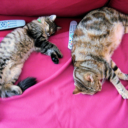

In [74]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw) # PIL image of shape (H,W,C)

image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into torch Tensor of shape CHW, divide by 255
    Lambda(lambda t: (t * 2) - 1),

])

x_start = transform(image).unsqueeze(0)
# print(type(x_start))
print(x_start.shape)

import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

reverse_transform(x_start.squeeze())

### Forward Diffusion process
Adding noise using the formulae

$$
q(x_t | x) = \mathcal{N}(x_t; \sqrt{\alpha_t} x_0, (1-\alpha_t)I )
$$

In [35]:
def q_sample(x_start, t, noise=None):
    """
    A function that takes a starting image (x_start) and does a forward diffusion
    to step t, and returns the noisy image.
    """
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def get_noisy_image(x_start, t):
    """
    Adds noise and turns the image (x_start) to a noisy image at step t.

    This is required, as every image in the batch, will have a different t value while training.
    """
    x_noisy = q_sample(x_start, t=t)
    noisy_image = reverse_transform(x_noisy.squeeze())

    return noisy_image

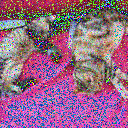

In [36]:
# take time step
t = torch.tensor([40])

get_noisy_image(x_start, t)

Visualising the noising process (even this took a long time, around 10 sec on CPU)

In [37]:
import matplotlib.pyplot as plt

torch.manual_seed(0)

def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [66]:
len([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

<PIL.Image.Image image mode=RGB size=128x128 at 0x7D9F58F5EC50>


In [38]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])


### Loss function
The loss function is the difference between the actual loss added to the model, and the loss predicted by the denoiser.

The full training algorithm is as follows:-

<img src="./Images/Algo1.png" width="400px"></img>

In [39]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    """
    Function defining the loss over the noise of denoising function.

    Inputs: Denoising model, x_start (image), t (time step), noise (noise added)

    It samples a x_noisy image based on the start and noise added, and then difference with actual
    """
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

## Dataset and Dataloader

The dataset simply consists of images from a real dataset, like Fashion-MNIST, CIFAR-10 or ImageNet, scaled linearly to [−1,1].

In [40]:
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader

image_size = 28
channels = 1
batch_size = 128
torch.manual_seed(0)

# Loading dataset from the Hugging face hub
dataset = load_dataset("fashion_mnist")

# Define Image transformations (using torchvision), including a random horizontal flip
# The data is [0,1], so converted to [-1,+1]
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# Define Transform function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# Create a pytorch Dataloader Object
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

In [41]:
batch = next(iter(dataloader))
print(batch.keys())

# Each batch has 128 images of size 28x28
print(batch['pixel_values'].shape)

num_batches = len(dataloader)
print("num of batches: ",num_batches)
print("batch size: ", dataloader.batch_size)

total_images = len(dataloader.dataset)
print("Total no of images: ", total_images)

dict_keys(['pixel_values'])
torch.Size([128, 1, 28, 28])
num of batches:  469
batch size:  128
Total no of images:  60000


## Sampling from the denoising model

The sampling is mainly based on repeated application of the formulaes:-

The Algorithm is as follows:-

<img src="./Images/Algo2.png" width="400px"></img>

In [42]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    """
    Function sampling images from random noise, for a time step t.
    Takes the noisy image, and denoises it slightly.
    """
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper, which predicts the mean of x_{t-1}
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    """
    Performs a loop over the above function to get an image of the desired shape
    from random noise.
    """
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    """
    Takes in the image_size, and batch size, and produces the images.
    Note, it samples image of all timesteps
    """
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


## Training the Model

We train the model (the Unet) in the regular pytorch fashion. We also periodically save generated images. Note, we will be doing this for grayscale images so intial channels = 1.

In [43]:
from pathlib import Path

def num_to_groups(num, divisor):
    """
    Function: Divides a number into a List based on the divisor
    Inputs  : Two numbers
    Returns : List
    Example : num_to_groups(19, 4) gives [4, 4, 4, 4, 3]
    """
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [44]:
from torch.optim import Adam
import time

device = "cuda" if torch.cuda.is_available() else "cpu"

image_size = 28
channels = 1

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

from torchvision.utils import save_image

epochs = 6

start_time = time.time()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch["pixel_values"].shape[0]
      batch = batch["pixel_values"].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("Loss:", loss.item())

      loss.backward()
      optimizer.step()

      # save generated images
      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        batches = num_to_groups(4, batch_size)
        all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
        all_images = torch.cat(all_images_list, dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

end_time = time.time()
elapsed_time = end_time - start_time
print("Execution time:", elapsed_time, "seconds")

Loss: 0.3898801803588867
Loss: 0.06510451436042786
Loss: 0.048781491816043854
Loss: 0.04842105135321617
Loss: 0.04279200732707977
Loss: 0.04115411266684532
Loss: 0.03478191792964935
Loss: 0.045834366232156754
Loss: 0.04105312377214432
Loss: 0.040938083082437515
Loss: 0.03567332401871681
Loss: 0.03463039919734001
Loss: 0.037672258913517
Loss: 0.03306293115019798
Loss: 0.04342079162597656
Loss: 0.029836226254701614
Loss: 0.03612665832042694
Loss: 0.041026100516319275
Loss: 0.03876705840229988
Loss: 0.030764661729335785
Loss: 0.030851289629936218
Loss: 0.03403029963374138
Loss: 0.031532611697912216
Loss: 0.029334841296076775
Loss: 0.044259633868932724
Loss: 0.027836691588163376
Loss: 0.04047536104917526
Loss: 0.03577093780040741
Loss: 0.030916009098291397
Loss: 0.034666191786527634
Execution time: 423.3511366844177 seconds


In [84]:
save_path = 'DDPM_model.pth'

# Saving the model
torch.save(model.state_dict(), save_path)

In [ ]:
# Loading the model
load_path = 'model.pth'

# Instantiate your model (make sure the architecture matches the saved model)
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)

# Load the saved model parameters into the model instance
model.load_state_dict(torch.load(load_path))

### Model Charachteristics

In [87]:
import torch

# 1. Model Architecture (Too long)
print("Model Architecture:")
# print(model)

# 2. Model Parameters (Too long)
print("\nModel Parameters:")
# for name, param in model.named_parameters():
#     print(f"Parameter name: {name}, Shape: {param.shape}")

Model Architecture:

Model Parameters:


## Sampling from the Model

sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

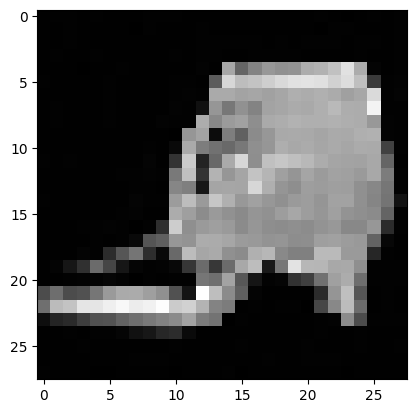

In [45]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

# show a random one
random_index = 5
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

In [76]:
plotting_images = []
for i in range(samples[-1].shape[0]):
  plotting_images.append(reverse_transform(torch.tensor(samples[-1][i])) )

In [83]:
dictionary = {'cmap': 'gray'}
plot(plotting_images[0:7],with_orig=False, row_title=None,cmap='gray')

A gif of the training process:

This execution fails

In [63]:
# import matplotlib.animation as animation

# random_index = 53

# fig = plt.figure()
# ims = []
# for i in range(timesteps):
#     im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
#     ims.append([im])

# animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
# animate.save('diffusion.gif')
# plt.show()